In [0]:
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [0]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=2.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def preprocessImage(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower = np.array([0,0,0])
    upper = np.array([179, 255, 209])
    mask = cv2.inRange(image, lower, upper)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    close = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    image[close==0] = (255,255,255)
    retouch_mask = (image <= [250.,250.,250.]).all(axis=2)
    image[retouch_mask] = [0,0,0]
    image = 255-image
    return image[...,0]

def getSplits(img, threshold, vertical=False):
#   height, width = img.shape
#   scaling = height/100
  # threshold is the percentage of height(0-100) needed for a line to be considered a line
#   threshold is the number of pixels needed for a line to considered a line between 1 and 1000
  if vertical:
    img = img.T
    img = cv2.dilate(img, np.ones((5,5), np.uint8), iterations=3)
  else:
    img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=1)
  h = np.sum(img,axis=1)
  h = 100*(h - h.min()) / (h.max() - h.min())
  zeros = np.where(h != 0)[0]
  zeroParts = np.split(zeros, np.where(np.diff(zeros) != 1)[0]+1)
  horizontalSplits = [(x[0], x[-1]) for x in zeroParts if x[-1]-x[0] > threshold]
  return horizontalSplits

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [0]:
files = [f for f in os.listdir('/dbfs/FileStore/shared_uploads/t-nbilla@expediagroup.com/IAM-Dataset')]
print(files)

['ascii', 'lines', 'r06_137.png', 'words']

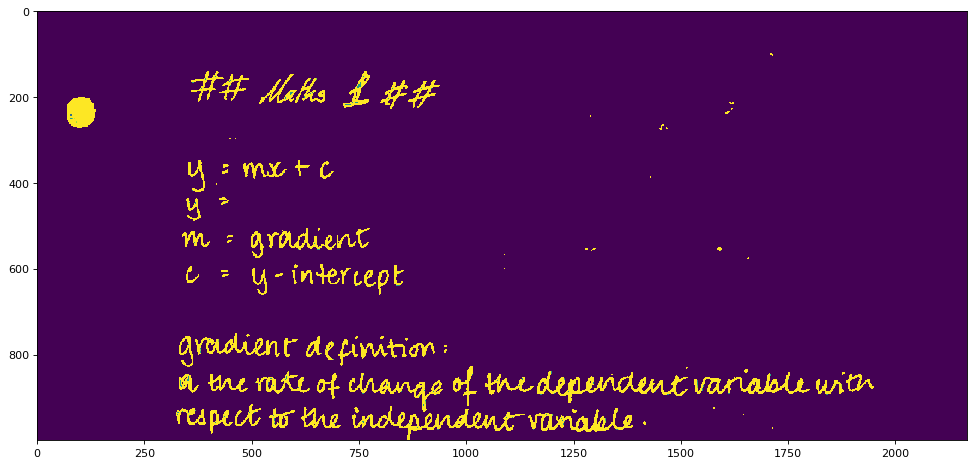

In [0]:
img = image_resize(cv2.imread('/dbfs/FileStore/shared_uploads/t-nbilla@expediagroup.com/IAM-Dataset/images2.png'), height=1000)
img2 = preprocessImage(img)
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(img2)
plt.show()

In [0]:
pageSplits = getHorizontalSplits(img2, 10)
data = []
for lineSplit in pageSplits:
  words = []
  line = img2[lineSplit[0]:lineSplit[1],:]
  wordSplits = getSplits(line, 40, vertical=True)
  for wordSplit in wordSplits:
    word = line[:,wordSplit[0]:wordSplit[1]]
    words.append(word)
#     x, y, w, h = cv2.boundingRect(word) # find the bounding rectangle of nonzero points in the image
#     words.append(word[y:y+h, x:x+w])

  data.append(words)

Out[124]:

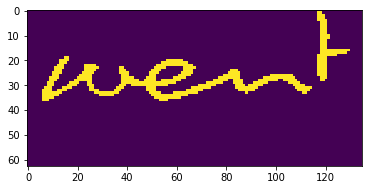

<matplotlib.image.AxesImage at 0x7f27d03e8090>

In [0]:
plt.imshow(data[2][3])

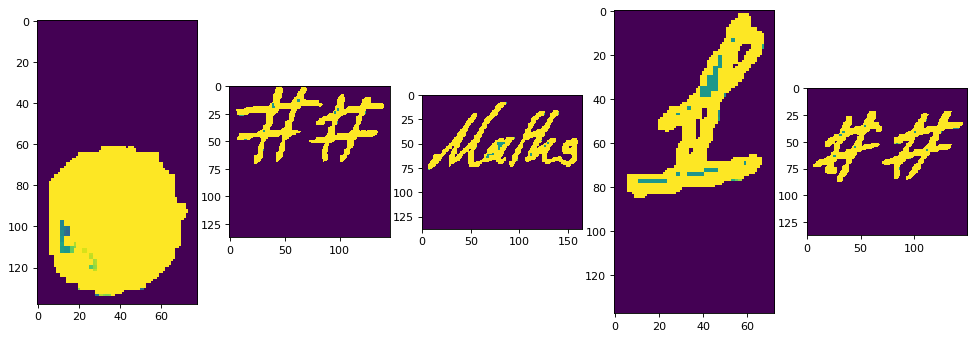

In [0]:
specificLine = data[0]
fig, ax = plt.subplots(1, len(specificLine), figsize=(15, 10), dpi=80)
for i in range(len(specificLine)):
    ax[i].imshow(specificLine[i])

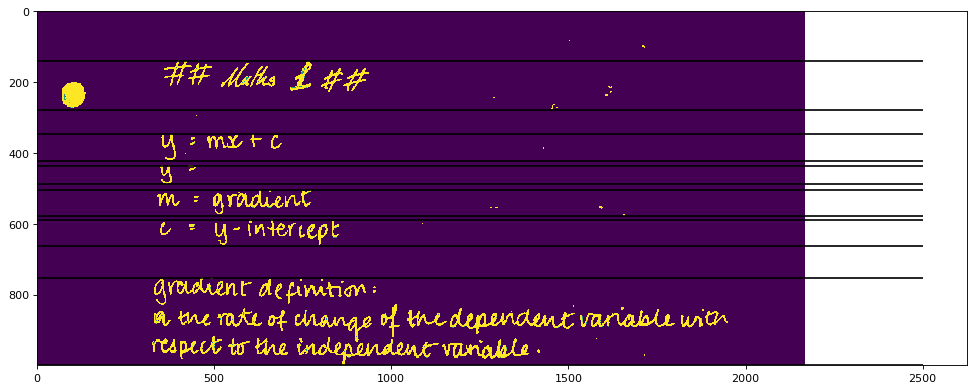

In [0]:
plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(img2)
plt.hlines(np.concatenate(pageSplits), 0, 2500)
plt.show()